Goal: To achieve an accuracy of over 80% using demographic data (gender) and anthropometric data (grip).

Import part

In [11]:
# pandas is used for deal with CSV
import pandas as pd
import numpy as np
import seaborn as sns
import math
# used in devide data to train and test
from sklearn.model_selection import train_test_split
# used to train by fit method
from sklearn.ensemble import RandomForestClassifier
# probabilities using scikit-learn's roc_auc_score method
from sklearn.metrics import roc_auc_score
# produce a confusion matrix for the model
from sklearn.metrics import confusion_matrix
# quantify the precision of the model
from sklearn.metrics import precision_score
# measure the model's recall
from sklearn.metrics import recall_score
# for drow roc curve
from sklearn.metrics import roc_curve

%matplotlib inline
import matplotlib.pyplot as plt

Data processing for df

In [12]:
# read all csv in different df
df1 = pd.read_csv('Input/demographic.csv')
df2 = pd.read_csv('Input/examination.csv')
df3 = pd.read_csv('Input/labs.csv')
df4 = pd.read_csv('Input/questionnaire.csv')

In [13]:
# there are lotd of unimportant information, just choose useful imformation
df1 = df1[["SEQN", "RIAGENDR", "RIDAGEYR"]]
df2 = df2[["BPXSY1", "BPXSY2", "BPXSY3", "BPXSY4", 
           "BPXDI1", "BPXDI2", "BPXDI3", "BPXDI4"]]
df3 = df3[["LBXTC"]]
df4 = df4[["SMD030", "SMQ050Q", "SMD057", "BPD035",  
           "DPQ010", "DPQ020", "DPQ030", "DPQ040", "DPQ050", 
           "DPQ060", "DPQ070", "DPQ080", "DPQ090", "WHD020", 
           "DID040", "MCQ160B", "MCQ160C", "MCQ160D", "MCQ160E", 
           "MCQ300C"]]

# Put all the dfs together to df
df = pd.concat([df1, df2], axis=1, join='inner')
df = pd.concat([df, df3], axis=1, join='inner')
df = pd.concat([df, df4], axis=1, join='inner')

In [14]:
# check something lost or not
df.isnull().values.any()

True

In [15]:
# find where information lost
df.isnull().sum()

SEQN           0
RIAGENDR       0
RIDAGEYR       0
BPXSY1      2641
BPXSY2      2404
BPXSY3      2405
BPXSY4      9298
BPXDI1      2641
BPXDI2      2404
BPXDI3      2405
BPXDI4      9298
LBXTC       2189
SMD030      7329
SMQ050Q     8515
SMD057      8515
BPD035      7728
DPQ010      4613
DPQ020      4615
DPQ030      4616
DPQ040      4616
DPQ050      4616
DPQ060      4617
DPQ070      4617
DPQ080      4617
DPQ090      4618
WHD020      3617
DID040      9100
MCQ160B     4252
MCQ160C     4252
MCQ160D     4252
MCQ160E     4252
MCQ300C     4252
dtype: int64

In [16]:
# DPQ010~090: NaN meams do not have this problem
# BPXDI1~4/BPXSY1~4: mean the different times for checking the blood pressures, 
# if donot have any data in 2~4, make it become 0, same with BPXDI1~4
# SMD030 means the year of smoking, NAN means nevery smoke
# SMQ050Q means time of quit smoking, NAN means nevery smoke or do not quit smoke
# SMD057 how many cigarettes did {you/SP} usually smoke per day, NAN means nevery smoke
# BPD035 the year of high blood pressure, NAN meanns no
# PAD means sport NAN means do not has any sport
# NaN means no pregnancy, which means 0 mounth
# MCQ300 if whether your relative have this problem
# MACQ160B~E if you have any problem or not
df = df.fillna({'DPQ010': 0, 'DPQ020': 0, 'DPQ030': 0, 
                'DPQ040': 0, 'DPQ050': 0, 'DPQ060': 0, 
                'DPQ070': 0, 'DPQ080': 0,'DPQ090': 0, 
                'BPXSY1': 0, 'BPXSY2': 0, 'BPXSY3': 0, 
                'BPXSY4': 0, 'BPXDI1': 0, 'BPXDI2': 0, 
                'BPXDI3': 0, 'BPXDI4': 0, 'SMD030': 0, 
                'SMQ050Q': 0,'SMD057': 0, 'BPD035': 0, 
                'DID040': 0, 'MCQ300C': 0, 'MCQ160B' : 0, 
                'MCQ160C': 0, 'MCQ160D' : 0, 'MCQ160E' : 0})

# recheck
df.isnull().sum()

SEQN           0
RIAGENDR       0
RIDAGEYR       0
BPXSY1         0
BPXSY2         0
BPXSY3         0
BPXSY4         0
BPXDI1         0
BPXDI2         0
BPXDI3         0
BPXDI4         0
LBXTC       2189
SMD030         0
SMQ050Q        0
SMD057         0
BPD035         0
DPQ010         0
DPQ020         0
DPQ030         0
DPQ040         0
DPQ050         0
DPQ060         0
DPQ070         0
DPQ080         0
DPQ090         0
WHD020      3617
DID040         0
MCQ160B        0
MCQ160C        0
MCQ160D        0
MCQ160E        0
MCQ300C        0
dtype: int64

In [17]:
# check other NAN data
df[df.isnull().values.any(axis=1)].head()

,SEQN,RIAGENDR,RIDAGEYR,BPXSY1,BPXSY2,BPXSY3,BPXSY4,BPXDI1,BPXDI2,BPXDI3,...,DPQ070,DPQ080,DPQ090,WHD020,DID040,MCQ160B,MCQ160C,MCQ160D,MCQ160E,MCQ300C
3,73560,1,9,108.0,102.0,104.0,0.0,38.0,34.0,38.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
6,73563,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
11,73568,2,26,102.0,104.0,102.0,0.0,44.0,42.0,40.0,...,0.0,0.0,0.0,105.0,0.0,2.0,2.0,2.0,2.0,2.0
12,73569,2,0,124.0,0.0,128.0,128.0,68.0,0.0,68.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
13,73570,2,9,88.0,88.0,94.0,0.0,54.0,54.0,58.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# delate NaN information
df = df.dropna()

# rechack
df.isnull().values.any()

False

In [19]:
# delate unnormal information
for index, row in df.iterrows():
    # unnormal information stored in SMD030 is 999
    if row['SMD030'] >= 100:
        df = df.drop(index)
        continue
    if row['SMD057'] >= 200:
        df = df.drop(index)
        continue
    if row['BPD035'] >= 200:
        df = df.drop(index)
        continue
    if row['WHD020'] >= 1000:
        df = df.drop(index)
        continue
    if row['DID040'] >= 100:
        df = df.drop(index)
        continue
    
    if row['MCQ160B'] == 9:
        df.loc[index,'MCQ160B'] = 0
    if row['MCQ160C'] == 9:
        df.loc[index,'MCQ160C'] = 0
    if row['MCQ160D'] == 9:
        df.loc[index,'MCQ160D'] = 0
    if row['MCQ160E'] == 9:
        df.loc[index,'MCQ160E'] = 0
    if row['MCQ300C'] == 9:
        df.loc[index,'MCQ300C'] = 0
    
df.describe()

,SEQN,RIAGENDR,RIDAGEYR,BPXSY1,BPXSY2,BPXSY3,BPXSY4,BPXDI1,BPXDI2,BPXDI3,...,DPQ070,DPQ080,DPQ090,WHD020,DID040,MCQ160B,MCQ160C,MCQ160D,MCQ160E,MCQ300C
count,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,...,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000
mean,78559.354586,1.527642,45.277060,103.650498,107.323025,107.134929,8.016522,57.790299,59.397585,59.262021,...,0.248676,0.146791,0.044906,175.342089,5.191273,1.753230,1.743063,1.760008,1.747511,1.397797
std,2809.244607,0.499288,19.191936,42.167471,38.458046,38.135805,31.277390,25.728325,24.021524,24.180627,...,0.669248,0.531881,0.321042,46.838332,15.819910,0.636714,0.642976,0.633642,0.638628,0.698506
min,73557.000000,1.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,76156.000000,1.000000,29.000000,102.000000,102.000000,102.000000,0.000000,52.000000,54.000000,54.000000,...,0.000000,0.000000,0.000000,142.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000
50%,78634.000000,2.000000,44.000000,112.000000,114.000000,114.000000,0.000000,64.000000,66.000000,66.000000,...,0.000000,0.000000,0.000000,170.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,80966.000000,2.000000,61.000000,126.000000,126.000000,126.000000,0.000000,74.000000,74.000000,74.000000,...,0.000000,0.000000,0.000000,200.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,83368.000000,2.000000,80.000000,220.000000,212.000000,218.000000,212.000000,120.000000,112.000000,118.000000,...,9.000000,9.000000,9.000000,493.000000,80.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [20]:
# Consolidate data
for index, row in df.iterrows():
    # 10, 

    i = 0
    if row['DPQ010'] > 0: i = 1
    if row['DPQ020'] > 0: i+= 1
    if row['DPQ030'] > 0: i+= 1
    if row['DPQ040'] > 0: i+= 1
    if row['DPQ050'] > 0: i+= 1
    if row['DPQ060'] > 0: i+= 1
    if row['DPQ070'] > 0: i+= 1
    if row['DPQ080'] > 0: i+= 1
    if row['DPQ090'] > 0: i+= 1
    df.loc[index,'DPQ010'] = i
    
    # find the average Systolic Blood Pressure, Diastolic Blood Pressure
    i = 0
    j = 0
    if row['BPXSY1'] > 0: 
        j = row['BPXSY1']
        i+=1
    if row['BPXSY2'] > 0: 
        j+= row['BPXSY2']
        i+=1
    if row['BPXSY3'] > 0: 
        j+= row['BPXSY3']
        i+=1
    if row['BPXSY4'] > 0: 
        j+= row['BPXSY4']
        i+=1
    if i > 0:
        df.loc[index,'BPXSY1'] = math.floor(j / i)
    i = 0
    j = 0
    if row['BPXDI1'] > 0: 
        j+= row['BPXDI1']
        i+=1
    if row['BPXDI2'] > 0: 
        j+= row['BPXDI2']
        i+=1
    if row['BPXDI3'] > 0: 
        j+= row['BPXDI3']
        i+=1
    if row['BPXDI4'] > 0: 
        j+= row['BPXDI4']
        i+=1
    if i > 0:
        df.loc[index,'BPXDI1'] = math.floor(j / i)
    
    # deal with the most important part, it has MCQ(1) or not(0)
    if row['MCQ160B'] == 2 or row['MCQ160C'] == 2 or row['MCQ160D'] == 2 or row['MCQ160E'] == 2:
        df.loc[index,'MCQ160B'] = 1
    else:
        df.loc[index,'MCQ160B'] = 0
    if row['MCQ300C'] > 0:
        df.loc[index,'MCQ300C'] = row['MCQ300C'] - 1

# there are lotd of unimportant information, just choose useful imformation
df = df[["SEQN", "RIAGENDR", "RIDAGEYR",  "BPXSY1", 
         "BPXDI1", "LBXTC", "SMD030", "SMQ050Q", "SMD057", "BPD035", 
         "MCQ300C", "MCQ160B", "DPQ010", "WHD020", "DID040"]]
df.describe()

,SEQN,RIAGENDR,RIDAGEYR,BPXSY1,BPXDI1,LBXTC,SMD030,SMQ050Q,SMD057,BPD035,MCQ300C,MCQ160B,DPQ010,WHD020,DID040
count,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000
mean,78559.354586,1.527642,45.277060,108.828003,60.621902,179.683542,6.727600,610.587376,2.933700,15.112264,0.521923,0.887947,1.795806,175.342089,5.191273
std,2809.244607,0.499288,19.191936,35.983207,22.015086,41.239337,9.245655,6659.822063,8.692538,23.364659,0.499572,0.315464,2.237165,46.838332,15.819910
min,73557.000000,1.000000,16.000000,0.000000,0.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,0.000000
25%,76156.000000,1.000000,29.000000,103.000000,55.000000,151.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,142.000000,0.000000
50%,78634.000000,2.000000,44.000000,114.000000,66.000000,176.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,170.000000,0.000000
75%,80966.000000,2.000000,61.000000,126.000000,74.000000,204.000000,16.000000,0.000000,0.000000,34.000000,1.000000,1.000000,3.000000,200.000000,0.000000
max,83368.000000,2.000000,80.000000,216.000000,128.000000,813.000000,64.000000,99999.000000,95.000000,80.000000,1.000000,1.000000,9.000000,493.000000,80.000000


In [21]:
df.shape

(4721, 15)

In [22]:
# deal with smorking and high blood pressure and hypertension
# reorder the index
i = 1
for index, row in df.iterrows():
    # RIDAGEYR is age, SMD030 is start year for smoking, SMD050Q is the time for quiting smoking to now
    # RIDAGEYR - SMD030 means the year for smoking to now
    j = row['RIDAGEYR'] - row['SMD030']
    
    # than - quiting time to get the real somking year(delate unnormal infomation)
    if row['SMQ050Q'] <= j:
        j = j - row['SMQ050Q']
    
    # if never smok, smokeage = 0
    if row['SMD030'] == 0:
        j = 0
    df.loc[index,'SMD030'] = j
    
    # RIDAGEYR is age, DID040 is start year for diabetes
    # RIDAGEYR - DID040 means the year for diabetes to now
    j = 0
    if row['DID040'] > 0:
        j = row['RIDAGEYR'] - row['DID040']
    df.loc[index,'DID040'] = j
    
    # RIDAGEYR is age, BPD035 is start year for hypertension
    # RIDAGEYR - BPD035 means the year for hypertension to now
    j = 0
    if row['BPD035'] > 0:
        j = row['RIDAGEYR'] - row['BPD035']
    df.loc[index,'BPD035'] = j
    
    index = i
    i+=1

# redelate useless information, just choose useful imformation
df = df.drop('SMQ050Q', axis=1)

# rename this information to better understanding and read
df = df.rename(columns = {'SEQN' : 'ID',
                          'RIAGENDR' : 'Gender',
                          'RIDAGEYR' : 'Age',
                          'RIDEXPRG' : 'Pregnancy',
                          'BPXSY1' : 'SystolicBloodPressure',
                          'BPXDI1' : 'DiastolicBloodPressure',
                          'LBXTC' : 'Cholesterol',
                          'SMD030' : 'SmokeAge',
                          'SMD057' : 'SmokingFrequency',
                          'BPD035' : 'HypertensiveAge',
                          'MCQ300C' : 'Heredity',
                          'MCQ160B' : 'CVD',
                          'DID040' : 'DiabeticAge',
                          'DPQ010' : 'Depression',
                          'WHD020' : 'Weight'})

# chek the infomation right or not
df.describe()

,ID,Gender,Age,SystolicBloodPressure,DiastolicBloodPressure,Cholesterol,SmokeAge,SmokingFrequency,HypertensiveAge,Heredity,CVD,Depression,Weight,DiabeticAge
count,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000
mean,78559.354586,1.527642,45.277060,108.828003,60.621902,179.683542,9.074349,2.933700,3.944080,0.521923,0.887947,1.795806,175.342089,1.208642
std,2809.244607,0.499288,19.191936,35.983207,22.015086,41.239337,15.223344,8.692538,8.603424,0.499572,0.315464,2.237165,46.838332,4.680683
min,73557.000000,1.000000,16.000000,0.000000,0.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,0.000000
25%,76156.000000,1.000000,29.000000,103.000000,55.000000,151.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,142.000000,0.000000
50%,78634.000000,2.000000,44.000000,114.000000,66.000000,176.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,170.000000,0.000000
75%,80966.000000,2.000000,61.000000,126.000000,74.000000,204.000000,15.000000,0.000000,3.000000,1.000000,1.000000,3.000000,200.000000,0.000000
max,83368.000000,2.000000,80.000000,216.000000,128.000000,813.000000,71.000000,95.000000,63.000000,1.000000,1.000000,9.000000,493.000000,50.000000


Start to ML

In [23]:
# data -> attributes, target -> CVD
data = df.loc[:,df.columns!='CVD'].values[:,1:]
target = df.loc[:,'CVD'].values

# show has CVD or not
print(target[target==1].shape, target[target==0].shape)

(4192,) (529,)


In [24]:
# x = scaler.fit_transform(data)
x = data
y = target

In [25]:
# 80% for training, 20% for testing
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [26]:
# check the number of train and test
print(x_train.shape, x_test.shape)

(3776, 12) (945, 12)


In [27]:
# train it by calling the fit method.
model = RandomForestClassifier(random_state=13)
model.fit(x_train, y_train)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [28]:
# predicted the result
predicted = model.predict(x_test)
model.score(x_test, y_test)

0.9968253968253968

In [29]:
# it already get nearly 100% right, generate an ROC AUC score from the probabilities using scikit-learn's roc_auc_score method
probabilities = model.predict_proba(x_test)
roc_auc_score(y_test, probabilities[:, 1])

0.9941017742436182

In [30]:
# produce a confusion matrix for the model
confusion_matrix(y_test, predicted)

array([[ 96,   3],
       [  0, 846]])

In [31]:
# quantify the precision of the model
train_predictions = model.predict(x_train)
precision_score(y_train, train_predictions)

0.9997012249775918

In [32]:
# measure the model's recall
recall_score(y_train, train_predictions)

1.0

In [33]:
# configures Seaborn to enhance the output from Matplotlib.
sns.set()

Text(0, 0.5, 'True Positive Rate')

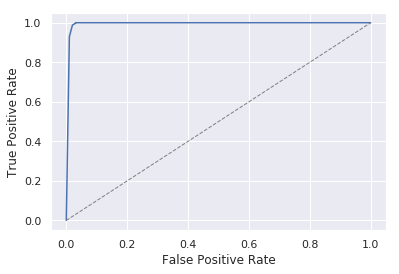

In [34]:
fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

end of program
too many factors can make the result better